# CF 06 - Stationarity Test - Synthetic Data

Resources:<p>
* https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638
* https://arch.readthedocs.io/en/latest/

If a series is stationary...
1. there is no trend
2. variance is constant
3. autocorrelation is constant
    

Assumptions:
* Time series are constant interval, 
* welds are *almost* constant interval
* Pipe replacements may screw things up, try w/out replacements?
    

### Autocorrelation
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html#statsmodels.tsa.stattools.acf


### ADF
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

https://www.statology.org/dickey-fuller-test-python/


### KPSS
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html#statsmodels.tsa.stattools.kpss


## Setup and Import Packages

In [6]:
import sys
import os 
from os.path import dirname
sys.path.append('/Users/Craig/Documents/MyStuff/00 Research/projects/dtw/Code/python')

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)


## Import Data

In [7]:
# Import data

data = ('./Data for stationarity tests-06-CF-metric-data.csv')

colNames = ['odoA','event','drift','diff1']

eventTypes = pd.CategoricalDtype(categories=['agm',
                                            'bend',
                                            'bweld',
                                            'casing',
                                            'weld'], ordered=False)

dataTypes = {'odoA':np.float_, 
             'event':eventTypes, 
             'drift':np.float_, 
             'diff1':np.float_}

df = pd.read_csv(data, skiprows=1, header=0, names=colNames)

df.name = 'Synthetic Data'
df.astype(dataTypes)

,odoA,event,drift,diff1
0,279.53,weld,-61.97,0.08
1,304.78,casing,-61.14,0.83
2,324.62,bweld,-61.91,-0.77
3,331.07,weld,-61.93,-0.02
4,373.51,weld,-61.99,-0.06
...,...,...,...,...
194,8060.69,weld,-45.80,0.11
195,8073.38,casing,-45.80,0.01
196,8105.86,bweld,-45.57,0.23
197,8141.18,agm,-46.12,-0.54


## Confirmation plot

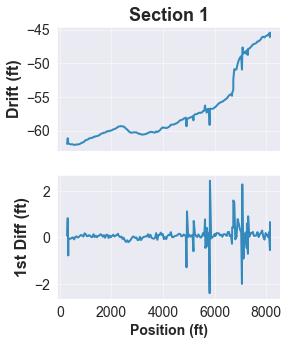

In [8]:
plt.rc("figure", figsize=(4, 5))
fig, axs = plt.subplots(2,1, sharex=True, sharey=False)
           
axs[0].plot(df.odoA, df.drift)
axs[1].plot(df.odoA, df.diff1)

axs[0].set_title('Section 1', fontdict={'fontsize':18, 'fontweight':'bold'})
axs[1].set_xlabel("Position (ft)", fontdict={'fontsize':14, 'fontweight':'bold'})
axs[0].set_ylabel('Drift (ft)', fontdict={'fontsize':16, 'fontweight':'bold'})
axs[1].set_ylabel('1st Diff (ft)', fontdict={'fontsize':16, 'fontweight':'bold'})
        
fig.show()
# fig.savefig('./CF Paper data section 1.pdf',  bbox_inches='tight')

## Joint Length Histograms


In [9]:
# get a set of joint lengths by subtracting adjacent wheel counts

dfLen=df[['odoA']].copy()
dfLen['wc_shift']=df[['odoA']].copy().shift(periods=1, fill_value=324.62)
dfLen['Joint_Length']=dfLen['odoA']-dfLen['wc_shift']
display(dfLen)

,odoA,wc_shift,Joint_Length
0,279.53,324.62,-45.09
1,304.78,279.53,25.25
2,324.62,304.78,19.84
3,331.07,324.62,6.45
4,373.51,331.07,42.44
...,...,...,...
194,8060.69,8018.78,41.91
195,8073.38,8060.69,12.69
196,8105.86,8073.38,32.48
197,8141.18,8105.86,35.32


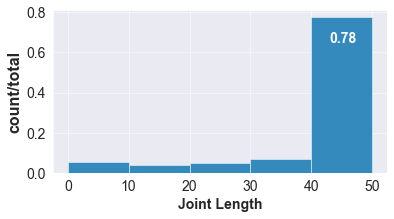

In [14]:
import statistics

numbins = 5
edge = 0.04

plt.rc("figure", figsize=(6, 3))
fig, axs = plt.subplots(1,1) 

# axs.set_title('Joint Lengths', fontdict={'fontsize':18, 'fontweight':'bold'})
axs.set_xlabel("Joint Length", fontdict={'fontsize':14, 'fontweight':'bold'})
axs.set_ylabel("count/total", fontdict={'fontsize':16, 'fontweight':'bold'})

axs.hist(dfLen['Joint_Length'],
                     bins=numbins,
                     range=(0,50),
                     weights=np.ones_like(dfLen['Joint_Length']) / len(dfLen['Joint_Length']),
                     density=False)

sz=0.78
axs.text(43, 0.65, '{:.2f}'.format(sz), fontdict={'color':'w', 'fontweight':'bold'})

fig.show()

# fig.savefig('./06-CF-metric-data-joint lengths-full-set.pdf')

## Population Statistics

Mean and variance tell us a lot about the stationarity.  Need a zero mean and constant variance. Also, no trend.

This is often done by splitting the sample into chunks and comparing them.

In [15]:
segs = [0, 0.25, 0.5, 0.75, 1]


print('Dataset : ', df.name, '\t Curve : ', 'diff1')   

for i in range(1,len(segs)):

    x = df.loc[round(len(df.odoA)*segs[i-1]):round(len(df.odoA)*segs[i]-1),'odoA']
    chunk = df.loc[round(len(df.odoA)*segs[i-1]):round(len(df.odoA)*segs[i]-1), 'diff1']

    slope, intercept = np.polyfit(x,chunk,1)
    m = chunk.mean()
    s = chunk.std()
    
    print(i, ': mean = ', round(m,3), '\t std = ', round(s,1), '\t slope = ', round(slope,3), '\t intercept = ', round(intercept,1))

    print(); print()

print(); print()


Dataset :  Synthetic Data 	 Curve :  diff1
1 : mean =  0.054 	 std =  0.2 	 slope =  0.0 	 intercept =  0.0


2 : mean =  0.011 	 std =  0.1 	 slope =  0.0 	 intercept =  -0.3


3 : mean =  0.068 	 std =  0.6 	 slope =  0.0 	 intercept =  -0.1


4 : mean =  0.198 	 std =  0.6 	 slope =  -0.0 	 intercept =  1.3






## Autocorrelation

Documentation : 
    [https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html#statsmodels.tsa.stattools.acf]

Parameters:
    
    * x : the 1D time series data (no gaps)
    * nlags : returned value includes lag 0, returns n+1 lags
    * alpha : (scalar) returns confidence intervals, alpha = 0.05 => 95% conf int
    

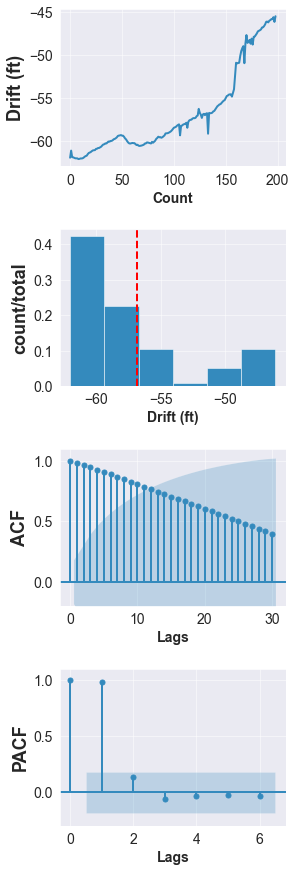

In [17]:
# PACF Quad 2x2
import statistics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.gridspec as gridspec

col = 'drift'

size = [(6, 12), (4, 12)]
plt.rc("figure", figsize=size[1])
# plt.rcParams["figure.constrained_layout.hspace"]

mu = df[[col]].mean()[0]
sigma = df[[col]].std()[0]

fig, axs = plt.subplots(4,1, 
                        sharex=False, sharey=False, 
                        layout='constrained', 
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.11})

i=0
# axs[0].set_title('Values')  
axs[i].set_ylabel("Drift (ft)", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Count", fontdict={'fontsize':14, 'fontweight':'bold'}) 
axs[i].plot(df[[col]])
# axs[i].set_ylim([-0.3,0.3])

# axs[i].axhline(mu, color='r', linestyle='dashed', linewidth=3) 
# axs[i].text(0.2, mu + mu*0.5 - 0.27, r'$\mu: {:.2f}$'.format(mu))


i=1
# axs[1].set_title('Distribution')
axs[i].set_ylabel("count/total", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Drift (ft)", fontdict={'fontsize':14, 'fontweight':'bold'}) 
numbins = 6
edge = 0.04

axs[i].hist(df[[col]],
             bins=numbins,
             range=(df[[col]].quantile(edge)[0],df[[col]].quantile(1-edge)[0]),
             weights=np.ones_like(df[[col]]) / len(df[[col]]),
             density=False)

axs[i].axvline(mu, color='r', linestyle='dashed', linewidth=2)  
min_ylim, max_ylim = axs[i].get_ylim()
# axs[i].text(mu+0.2, max_ylim*0.9, r'$\mu={:.2f}$'.format(mu))


i=2
axs[i].set_ylabel("ACF", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Lags", fontdict={'fontsize':14, 'fontweight':'bold'}) 
plot_acf(df[[col]], lags=30, alpha=0.01, ax=axs[i], zero=True, title=None)
axs[i].set_ylim([-0.2, 1.1])
# axs[i].set_xlim([-3, 40])

i=3
axs[i].set_ylabel("PACF", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Lags", fontdict={'fontsize':14, 'fontweight':'bold'})
plot_pacf(df[[col]], lags=6, alpha=0.01, ax=axs[i], zero=True, title=None)
axs[i].set_ylim([-0.3,1.1])


fig.show()


# fig.savefig('./06-CF-metric-data-drift-full-set-square-mu.pdf')
# fig.savefig('./06-CF-metric-data-drift-full-set-square-nomu.pdf')

# fig.savefig('./06-CF-metric-data-drift-full-set-wide-mu.pdf')
# fig.savefig('./06-CF-metric-data-drift-full-set-wide-nomu.pdf')

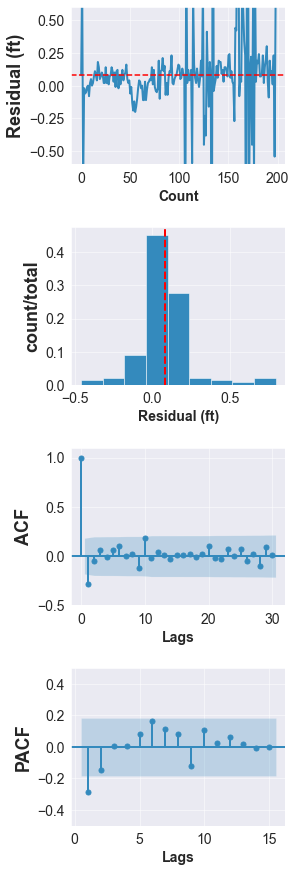

In [24]:
# PACF Quad 2x2
import statistics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.gridspec as gridspec

col = 'diff1'

size = [(6, 12), (4, 12)]
plt.rc("figure", figsize=size[1])

# plt.rcParams["figure.constrained_layout.hspace"]

mu = df[[col]].mean()[0]
sigma = df[[col]].std()[0]

fig, axs = plt.subplots(4,1, 
                        sharex=False, sharey=False, 
                        layout='constrained', 
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.11})

i=0
# axs[0].set_title('Values')  
axs[i].set_ylabel("Residual (ft)", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Count", fontdict={'fontsize':14, 'fontweight':'bold'}) 
axs[i].plot(df[[col]])
axs[i].set_ylim([-0.6,0.6])

axs[i].axhline(mu, color='r', linestyle='dashed', linewidth=1.5) 
# axs[i].text(0.2, mu + mu*0.5 - 0.27, r'$\mu: {:.2f}$'.format(mu))


i=1
# axs[1].set_title('Distribution')
axs[i].set_ylabel("count/total", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Residual (ft)", fontdict={'fontsize':14, 'fontweight':'bold'}) 
numbins = 9
edge = 0.04

axs[i].hist(df[[col]],
             bins=numbins,
             range=(df[[col]].quantile(edge)[0],df[[col]].quantile(1-edge)[0]),
             weights=np.ones_like(df[[col]]) / len(df[[col]]),
             density=False)

axs[i].axvline(mu, color='r', linestyle='dashed', linewidth=2)  
min_ylim, max_ylim = axs[i].get_ylim()
# axs[i].text(mu - mu*3.5, max_ylim*0.8, r'$\mu={:.2f}$'.format(mu))


i=2
axs[i].set_ylabel("ACF", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Lags", fontdict={'fontsize':14, 'fontweight':'bold'}) 
plot_acf(df[[col]], lags=30, alpha=0.01, ax=axs[i], zero=True, title=None)
axs[i].set_ylim([-0.5, 1.1])
# axs[i].set_xlim([-3, 40])

i=3
axs[i].set_ylabel("PACF", fontdict={'fontsize':18, 'fontweight':'bold'})
axs[i].set_xlabel("Lags", fontdict={'fontsize':14, 'fontweight':'bold'})
plot_pacf(df[[col]], lags=15, alpha=0.01, ax=axs[i], zero=False, title=None)
axs[i].set_ylim([-0.5,0.5])


fig.show()

# fig.savefig('./06-CF-metric-data-diff-full-set-square-mu.pdf')
# fig.savefig('./06-CF-metric-data-diff-full-set-square-nomu.pdf')

# fig.savefig('./06-CF-metric-data-diff-full-set-wide-mu.pdf')
# fig.savefig('./06-CF-metric-data-diff-full-set-wide-nomu.pdf')

## Augmented Dicky-Fuller

Documentation: 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Parameters:
* x : the data series
* maxlag : Maximum lag which is included in test, default value of 12*(nobs/100)^{1/4} is used when None.
* regression{“c”,”ct”,”ctt”,”n”}
    * “c” : constant only (default).
    * “ct” : constant and trend.
    * “ctt” : constant, and linear and quadratic trend.
    * “nc” : no constant, no trend.

Returns:
* adf : Test statistic
* pvalue :  approximate p-value based on MacKinnon (1994, 2010).
* usedlagint : number of lags used
* nobs : number of observations used
* critical values : Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010). *dictionary*
* icbest : maximized information criterion if autolag is not None.

**Hypotheses**
* $H_0$: The series is not stationary, it is a random walk
* $H_a$: The series is stationary, with no offset and n trend

One-sided test. Reject $H_0$ if $z \le z_{\alpha}$

>Definition: The p-value is the probability we would get the sample we have or something more extreme if the null hypothesis were true.

So, the smaller the P-value, the more evidence there is in the sample data against the null hypothesis and for the alternative hypothesis.


## Augmented DF w/ ARCH Toolbox
References: 
* https://bashtage.github.io/arch/
* https://bashtage.github.io/arch/unitroot/generated/arch.unitroot.ADF.html#arch.unitroot.ADF

**Select Parameters:**
* x: 1D data series
* trend : {“n”, “c”, “ct”, “ctt”}, optional
    * n - no trend components
    * c - include a constanr (default)
    * ct - constant and linear time trend
    * ctt - constant and quadradic time trend
    
**Note:**
This is basically the same as above. Maybe a little easier to use since it uses properties rather than an array.

In [56]:
from arch.unitroot import ADF
col = 'diff1'

adf = ADF(df[[col]], lags = None, trend='c') 
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -12.966
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## KPSS Test

The Kwiatkowski, Phillips, Schmidt and Shin (KPSS) stationarity test.

Reference: 
https://bashtage.github.io/arch/unitroot/generated/arch.unitroot.KPSS.html#arch.unitroot.KPSS

Like ADF, the KPSS test is also a unit root test. This one is based around a linear regression, thus the test assumes the series is stationary. The null hypothesis is reversed from ADF.  Null is that the sequence is stationary.  The alternate is that it is stationary.

**Parameters:**
* x : 1D data series
* trend : {“c”, “ct”}, optional
    * c - include a constant
    * ct - include a constant and a linear trend
    
**Hypotheses:**
* $H_0$ : The series is stationary
* $H_a$ : The series is non-stationary

One-sided test. Reject $H_0$ if $z \ge z_{\alpha}$
 

In [52]:
# ALL events, full dataset

from arch.unitroot import KPSS
col = 'diff1'

display(df[[col]])

kpss = KPSS(df[[col]], lags = None, trend='c')
print(kpss.summary().as_text())


,diff1
0,0.08
1,0.83
2,-0.77
3,-0.02
4,-0.06
...,...
194,0.11
195,0.01
196,0.23
197,-0.54


    KPSS Stationarity Test Results   
Test Statistic                  0.663
P-value                         0.016
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [53]:
# weld events only, full dataset

from arch.unitroot import KPSS
col = 'diff1'

display(df[[col]].loc[df['event'].isin(['weld'])])

kpss = KPSS(df[[col]].loc[df['event'].isin(['weld'])], lags = None, trend='c')
print(kpss.summary().as_text())


,diff1
0,0.08
3,-0.02
4,-0.06
5,-0.05
6,-0.01
...,...
190,0.03
191,-0.09
192,0.19
193,0.08


    KPSS Stationarity Test Results   
Test Statistic                  0.907
P-value                         0.004
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


## Zivot-Andrews Test

Allows one structural break in the series.

Reference: <p>
https://bashtage.github.io/arch/unitroot/generated/arch.unitroot.ZivotAndrews.html#arch.unitroot.ZivotAndrews
    
 **Hypotheses**
* $H_0$: The series is not stationary, single structural break
* $H_a$: The series is stationary, with no offset and n trend

One-sided test. Reject $H_0$ if $z \le z_{\alpha}$

In [55]:
from arch.unitroot import ZivotAndrews

col = 'diff1'

za = ZivotAndrews(df[[col]], max_lags = None, trend='c')
print(za.summary().as_text())


        Zivot-Andrews Results        
Test Statistic                -14.146
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.
